# Multi-Population GA with MLflow Integration

This notebook demonstrates how to add MLflow tracking to your genetic algorithm experiments.

## Key MLflow Features Added:
- Experiment tracking with parameters and metrics
- Generation-by-generation metric logging
- Model and artifact logging
- Visualization tracking
- Comprehensive result logging

In [7]:
# Install MLflow if needed
!pip install mlflow

zsh:1: command not found: pip


In [8]:
# Standard imports
import pickle
import time
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
import warnings
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import os
from datetime import datetime

# MLflow imports
import mlflow
import mlflow.sklearn
from mlflow import log_metric, log_param, log_params, log_artifact

warnings.filterwarnings("ignore")

# Set random seeds
random.seed(42)
np.random.seed(42)

In [9]:
# MLflow Setup
mlflow.set_tracking_uri("mlruns")  # Local directory for MLflow artifacts
experiment_name = f"MultiPopGA_BreastCancer_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
mlflow.set_experiment(experiment_name)

print(f"🔬 MLflow Experiment: {experiment_name}")
print(f"📁 Tracking URI: {mlflow.get_tracking_uri()}")

2025/12/26 14:01:49 INFO mlflow.tracking.fluent: Experiment with name 'MultiPopGA_BreastCancer_20251226_140149' does not exist. Creating a new experiment.


🔬 MLflow Experiment: MultiPopGA_BreastCancer_20251226_140149
📁 Tracking URI: mlruns


In [10]:
# Configuration parameters - all in one place for easy tracking
ga_config = {
    # Population settings
    "n_populations": 4,
    "performance_pop_size": 60,
    "clinical_pop_size": 50,
    "efficiency_pop_size": 40,
    "diversity_pop_size": 50,
    "total_population": 200,
    
    # GA parameters
    "n_generations": 100,
    "migration_frequency": 10,
    "migration_rate": 0.05,
    "mutation_rate_base": 0.05,
    "crossover_rate_base": 0.8,
    "selection_pressure": 3,
    "tournament_size": 3,
    
    # Model parameters
    "rf_n_estimators": 100,
    "rf_class_weight": "balanced",
    "rf_random_state": 42,
    "test_size": 0.2,
    "cv_folds": 3,
    
    # Feature selection parameters
    "min_features": 10,
    "max_features": 70,
    "init_feature_prob": 0.3,
    
    # Fitness weights for different populations
    "performance_auc_weight": 0.8,
    "performance_clinical_weight": 0.15,
    "performance_efficiency_weight": 0.05,
    
    "clinical_auc_weight": 0.4,
    "clinical_clinical_weight": 0.5,
    "clinical_efficiency_weight": 0.1,
    
    "efficiency_auc_weight": 0.5,
    "efficiency_clinical_weight": 0.1,
    "efficiency_efficiency_weight": 0.4,
    
    "diversity_auc_weight": 0.6,
    "diversity_clinical_weight": 0.2,
    "diversity_diversity_weight": 0.2,
    
    # Other parameters
    "random_seed": 42,
    "verbose": True
}

In [11]:
# Start main MLflow run
with mlflow.start_run(run_name="MultiPopGA_Main") as main_run:
    # Log all configuration parameters
    mlflow.log_params(ga_config)
    
    # Set tags
    mlflow.set_tag("algorithm", "Multi-Population Genetic Algorithm")
    mlflow.set_tag("thesis_chapter", "Feature Selection")
    mlflow.set_tag("dataset", "PLCO Breast Cancer")
    mlflow.set_tag("framework", "Evolutionary Multi-Objective")
    
    print("🌍 Starting Multi-Population Genetic Algorithm with MLflow Tracking")
    print("="*70)
    print(f"MLflow Run ID: {main_run.info.run_id}")
    print(f"MLflow Run Name: {main_run.info.run_name}")
    
    # Load and preprocess data
    print("\n📊 Loading dataset...")
    data = pd.read_csv("preprocessed_breast_cancer_data.csv")
    X = data.drop(columns=['target'])
    y = data['target']
    
    # Log dataset information
    mlflow.log_param("n_samples", X.shape[0])
    mlflow.log_param("n_features_original", X.shape[1])
    mlflow.log_param("positive_class_ratio", y.sum() / len(y))
    mlflow.log_param("negative_class_ratio", (len(y) - y.sum()) / len(y))
    
    # Your existing preprocessing code...
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=ga_config['test_size'], 
        random_state=ga_config['random_seed']
    )
    
    print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"Train set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # Continue with preprocessing...

🌍 Starting Multi-Population Genetic Algorithm with MLflow Tracking
MLflow Run ID: d4906794851c418ba951a79a29e7ac89
MLflow Run Name: MultiPopGA_Main

📊 Loading dataset...
Dataset: 76085 samples, 105 features
Train set: 60868 samples
Test set: 15217 samples


In [12]:
# Function to log population metrics
def log_population_metrics(population, generation, prefix=""):
    """Log metrics for a population to MLflow"""
    if prefix:
        prefix = f"{prefix}_"
    
    # Calculate population statistics
    fitnesses = [ind.fitness for ind in population.individuals]
    aucs = [ind.auc for ind in population.individuals]
    n_features = [ind.n_features for ind in population.individuals]
    
    # Log metrics
    mlflow.log_metric(f"{prefix}avg_fitness", np.mean(fitnesses), step=generation)
    mlflow.log_metric(f"{prefix}best_fitness", np.max(fitnesses), step=generation)
    mlflow.log_metric(f"{prefix}std_fitness", np.std(fitnesses), step=generation)
    
    mlflow.log_metric(f"{prefix}avg_auc", np.mean(aucs), step=generation)
    mlflow.log_metric(f"{prefix}best_auc", np.max(aucs), step=generation)
    
    mlflow.log_metric(f"{prefix}avg_features", np.mean(n_features), step=generation)
    mlflow.log_metric(f"{prefix}min_features", np.min(n_features), step=generation)
    mlflow.log_metric(f"{prefix}max_features", np.max(n_features), step=generation)
    
    mlflow.log_metric(f"{prefix}diversity", population.diversity, step=generation)

# Function to log individual details
def log_individual_details(individual, name=""):
    """Log detailed metrics for an individual"""
    mlflow.log_metric(f"{name}_fitness", individual.fitness)
    mlflow.log_metric(f"{name}_auc", individual.auc)
    mlflow.log_metric(f"{name}_n_features", individual.n_features)
    mlflow.log_metric(f"{name}_clinical_score", individual.clinical_score)
    mlflow.log_metric(f"{name}_efficiency_score", individual.efficiency_score)
    mlflow.log_metric(f"{name}_diversity_score", individual.diversity_score)

In [13]:
# Modified evolution loop with MLflow tracking
def run_evolution_with_tracking(populations, n_generations, X_train, y_train):
    """Run evolution with comprehensive MLflow tracking"""
    
    evolution_history = defaultdict(dict)
    migration_events = []
    
    # Track start time
    start_time = time.time()
    
    for generation in range(n_generations):
        print(f"\n📈 Generation {generation + 1}/{n_generations}")
        
        # Evaluate all populations
        for pop in populations:
            pop.evaluate_population(X_train, y_train)
            
            # Log population metrics
            log_population_metrics(pop, generation, prefix=pop.specialty.lower())
            
            # Store in history
            evolution_history[generation][pop.specialty] = {
                'avg_fitness': pop.avg_fitness,
                'best_fitness': pop.best_individual.fitness,
                'best_auc': pop.best_individual.auc,
                'diversity': pop.diversity,
                'avg_features': np.mean([ind.n_features for ind in pop.individuals])
            }
        
        # Find and log global best
        all_individuals = [ind for pop in populations for ind in pop.individuals]
        global_best = max(all_individuals, key=lambda x: x.fitness)
        
        mlflow.log_metric("global_best_fitness", global_best.fitness, step=generation)
        mlflow.log_metric("global_best_auc", global_best.auc, step=generation)
        mlflow.log_metric("global_best_n_features", global_best.n_features, step=generation)
        
        # Migration
        if generation % ga_config['migration_frequency'] == 0 and generation > 0:
            print("   🔄 Migration event")
            perform_migration(populations)
            migration_events.append(generation)
            mlflow.log_metric("migration_event", 1, step=generation)
        
        # Evolution step
        for pop in populations:
            pop.evolve_population()
        
        # Log progress
        if generation % 10 == 0:
            elapsed_time = time.time() - start_time
            mlflow.log_metric("elapsed_time_seconds", elapsed_time, step=generation)
            print(f"   ⏱️  Elapsed time: {elapsed_time:.2f} seconds")
    
    # Log final statistics
    total_time = time.time() - start_time
    mlflow.log_metric("total_evolution_time_seconds", total_time)
    mlflow.log_metric("avg_time_per_generation", total_time / n_generations)
    mlflow.log_metric("total_migration_events", len(migration_events))
    
    return evolution_history, migration_events

In [14]:
# Function to evaluate and log final results
def evaluate_final_results(populations, X_train, y_train, X_test, y_test, feature_names):
    """Evaluate best individuals from each population and log results"""
    
    print("\n🎯 Final Evaluation Phase")
    final_results = []
    
    for pop in populations:
        # Create nested run for final evaluation
        with mlflow.start_run(run_name=f"{pop.specialty}_Final_Evaluation", nested=True):
            
            best_ind = pop.best_individual
            selected_features = best_ind.selected_features()
            selected_feature_names = [feature_names[i] for i in selected_features]
            
            # Log population info
            mlflow.log_param("population_specialty", pop.specialty)
            mlflow.log_param("n_selected_features", len(selected_features))
            
            # Train final model
            rf_final = RandomForestClassifier(
                n_estimators=ga_config['rf_n_estimators'],
                class_weight=ga_config['rf_class_weight'],
                random_state=ga_config['rf_random_state']
            )
            rf_final.fit(X_train.iloc[:, selected_features], y_train)
            
            # Evaluate on test set
            y_pred = rf_final.predict(X_test.iloc[:, selected_features])
            y_proba = rf_final.predict_proba(X_test.iloc[:, selected_features])[:, 1]
            
            # Calculate metrics
            test_auc = roc_auc_score(y_test, y_proba)
            test_precision = precision_score(y_test, y_pred)
            test_recall = recall_score(y_test, y_pred)
            test_f1 = f1_score(y_test, y_pred)
            
            # Log test metrics
            mlflow.log_metric("test_auc", test_auc)
            mlflow.log_metric("test_precision", test_precision)
            mlflow.log_metric("test_recall", test_recall)
            mlflow.log_metric("test_f1", test_f1)
            mlflow.log_metric("train_auc", best_ind.auc)
            
            # Log the model
            mlflow.sklearn.log_model(rf_final, "model")
            
            # Save feature list
            feature_file = f"{pop.specialty}_features.txt"
            with open(feature_file, "w") as f:
                f.write("\n".join(selected_feature_names))
            mlflow.log_artifact(feature_file)
            
            # Feature importance
            importance_df = pd.DataFrame({
                'feature': selected_feature_names,
                'importance': rf_final.feature_importances_
            }).sort_values('importance', ascending=False)
            
            importance_file = f"{pop.specialty}_feature_importance.csv"
            importance_df.to_csv(importance_file, index=False)
            mlflow.log_artifact(importance_file)
            
            # Store results
            final_results.append({
                'Population': pop.specialty,
                'Train AUC': best_ind.auc,
                'Test AUC': test_auc,
                'Precision': test_precision,
                'Recall': test_recall,
                'F1': test_f1,
                'N Features': len(selected_features),
                'Clinical Score': best_ind.clinical_score,
                'Efficiency Score': best_ind.efficiency_score
            })
            
            print(f"\n{pop.specialty} Population:")
            print(f"  Test AUC: {test_auc:.4f}")
            print(f"  Features: {len(selected_features)}")
    
    return final_results

In [15]:
# Function to create and log visualizations
def create_and_log_visualizations(evolution_history, final_results, populations):
    """Create comprehensive visualizations and log to MLflow"""
    
    print("\n📊 Creating visualizations...")
    
    # 1. Evolution plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Multi-Population GA Evolution', fontsize=16)
    
    # Plot fitness evolution
    ax = axes[0, 0]
    for pop_name in ['Performance', 'Clinical', 'Efficiency', 'Diversity']:
        generations = sorted(evolution_history.keys())
        best_fitness = [evolution_history[g][pop_name]['best_fitness'] for g in generations]
        ax.plot(generations, best_fitness, label=pop_name, linewidth=2)
    ax.set_xlabel('Generation')
    ax.set_ylabel('Best Fitness')
    ax.set_title('Best Fitness Evolution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot AUC evolution
    ax = axes[0, 1]
    for pop_name in ['Performance', 'Clinical', 'Efficiency', 'Diversity']:
        best_auc = [evolution_history[g][pop_name]['best_auc'] for g in generations]
        ax.plot(generations, best_auc, label=pop_name, linewidth=2)
    ax.set_xlabel('Generation')
    ax.set_ylabel('Best AUC')
    ax.set_title('Best AUC Evolution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot feature count evolution
    ax = axes[1, 0]
    for pop_name in ['Performance', 'Clinical', 'Efficiency', 'Diversity']:
        avg_features = [evolution_history[g][pop_name]['avg_features'] for g in generations]
        ax.plot(generations, avg_features, label=pop_name, linewidth=2)
    ax.set_xlabel('Generation')
    ax.set_ylabel('Average Features')
    ax.set_title('Average Feature Count Evolution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot diversity evolution
    ax = axes[1, 1]
    for pop_name in ['Performance', 'Clinical', 'Efficiency', 'Diversity']:
        diversity = [evolution_history[g][pop_name]['diversity'] for g in generations]
        ax.plot(generations, diversity, label=pop_name, linewidth=2)
    ax.set_xlabel('Generation')
    ax.set_ylabel('Population Diversity')
    ax.set_title('Population Diversity Evolution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    evolution_plot_file = "evolution_plots.png"
    plt.savefig(evolution_plot_file, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(evolution_plot_file)
    plt.close()
    
    # 2. Final results comparison
    results_df = pd.DataFrame(final_results)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Final Results Comparison', fontsize=16)
    
    # AUC comparison
    ax = axes[0, 0]
    x = np.arange(len(results_df))
    width = 0.35
    ax.bar(x - width/2, results_df['Train AUC'], width, label='Train AUC', alpha=0.8)
    ax.bar(x + width/2, results_df['Test AUC'], width, label='Test AUC', alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['Population'], rotation=45)
    ax.set_ylabel('AUC')
    ax.set_title('Train vs Test AUC')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Feature count
    ax = axes[0, 1]
    ax.bar(results_df['Population'], results_df['N Features'], alpha=0.8)
    ax.set_xlabel('Population')
    ax.set_ylabel('Number of Features')
    ax.set_title('Selected Features Count')
    ax.set_xticklabels(results_df['Population'], rotation=45)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Performance metrics
    ax = axes[1, 0]
    metrics = ['Precision', 'Recall', 'F1']
    x = np.arange(len(results_df))
    width = 0.25
    for i, metric in enumerate(metrics):
        ax.bar(x + i*width, results_df[metric], width, label=metric, alpha=0.8)
    ax.set_xticks(x + width)
    ax.set_xticklabels(results_df['Population'], rotation=45)
    ax.set_ylabel('Score')
    ax.set_title('Performance Metrics Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Efficiency vs Performance scatter
    ax = axes[1, 1]
    scatter = ax.scatter(results_df['N Features'], results_df['Test AUC'], 
                        s=200, alpha=0.6, c=range(len(results_df)), cmap='viridis')
    for i, pop in enumerate(results_df['Population']):
        ax.annotate(pop, (results_df['N Features'].iloc[i], results_df['Test AUC'].iloc[i]),
                   xytext=(5, 5), textcoords='offset points', fontsize=10)
    ax.set_xlabel('Number of Features')
    ax.set_ylabel('Test AUC')
    ax.set_title('Efficiency vs Performance Trade-off')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    results_plot_file = "final_results_plots.png"
    plt.savefig(results_plot_file, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(results_plot_file)
    plt.close()
    
    print("✅ Visualizations created and logged")

In [21]:
import pickle
import time
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import warnings
import random
import matplotlib.pyplot as plt
from collections import defaultdict
warnings.filterwarnings("ignore")
import mlflow
import mlflow.sklearn

# Set random seeds
random.seed(42)
np.random.seed(42)

print("🌍 Starting F1-Optimized Multi-Population Genetic Algorithm")
print("="*70)

# [DATA LOADING AND PREPROCESSING - SAME AS ORIGINAL]
print("📊 Loading dataset...")
data = pd.read_csv("preprocessed_breast_cancer_data_CORRECTED.csv")
X = data.drop(columns=['target'])
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Class distribution - Train: {np.bincount(y_train)}, Test: {np.bincount(y_test)}")

# Preprocessing
print("🔧 Preprocessing data...")
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

X_train_scaled = X_train_scaled.dropna(axis=1, how='all')
X_test_scaled = X_test_scaled[X_train_scaled.columns]

imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train_scaled)
X_test_imputed = imputer.transform(X_test_scaled)

X_train_scaled = pd.DataFrame(X_train_imputed, columns=X_train_scaled.columns)
X_test_scaled = pd.DataFrame(X_test_imputed, columns=X_train_scaled.columns)

feature_names = X_train_scaled.columns.tolist()
n_features = len(feature_names)
print(f"Final feature set: {n_features} features")

# Clinical expert ratings from your provided array
print("🧠 Loading clinical expert ratings...")

original_features = [
    'educat', 'marital', 'occupat', 'pipe', 'cigar', 'sisters', 'brothers', 'asp', 'ibup', 'fmenstr', 'menstrs',
    'miscar', 'tubal', 'tuballig', 'bbd', 'benign_ovcyst', 'endometriosis', 'uterine_fib', 'bq_adminm', 'lmenstr',
    'trypreg', 'prega', 'pregc', 'stillb', 'livec', 'fchilda', 'asppd', 'ibuppd', 'bcontrt', 'curhorm', 'thorm',
    'hyperten_f', 'hearta_f', 'stroke_f', 'emphys_f', 'bronchit_f', 'diabetes_f', 'polyps_f', 'arthrit_f', 'osteopor_f',
    'divertic_f', 'gallblad_f', 'bq_age', 'race7', 'hispanic_f', 'preg_f', 'hyster_f', 'ovariesr_f', 'bcontr_f',
    'horm_f', 'horm_stat', 'smoked_f', 'cigpd_f', 'cig_stat', 'cig_years', 'pack_years', 'bmi_20', 'bmi_50',
    'bmi_curr', 'bmi_curc', 'weight_f', 'weight20_f', 'weight50_f', 'height_f', 'menstrs_stat_type',
    'post_menopausal', 'bmi_20c', 'bmi_50c', 'colon_comorbidity', 'liver_comorbidity', 'fh_cancer','breast_fh','breast_fh_cnt' ,'breast_fh_age', 'bq_compdays',
    'entryage_bq', 'entryage_dhq', 'entryage_sqx', 'ph_any_bq', 'ph_any_dhq', 'ph_any_sqx', 'ph_any_trial',
    'entrydays_bq', 'entrydays_dhq', 'entrydays_sqx', 'center', 'rndyear', 'arm', 'age', 'agelevel',
    'reconsent_outcome', 'reconsent_outcome_days', 'fstcan_exitstat', 'fstcan_exitage', 'fstcan_exitdays',
    'in_TGWAS_population'
]

# Clinical importance ratings (scale 0-5, normalized to 0-1)
clinical_ratings = [
    1, 1, 1, 3, 3, 5, 5, 2, 2, 5, 5, 5, 5, 5, 5, 2, 2, 2, 0, 5,
    5, 5, 5, 5, 5, 5, 2, 2, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2,
    2, 2, 0, 4, 4, 5, 5, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3,
    3, 3, 3, 3, 5, 5, 3, 3, 2, 2, 5, 5, 5, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0
]

# Normalize clinical ratings to 0-1 scale
clinical_ratings_norm = np.array(clinical_ratings) / 5.0
rating_dict = {feat: score for feat, score in zip(original_features, clinical_ratings_norm)}

# Expand to match current feature_names
expert_ratings = []
for fname in feature_names:
    base = fname
    if fname.startswith('race_'):
        base = 'race7'
    elif fname not in rating_dict:
        base = fname.split('_')[0] if '_' in fname else fname
    rating = rating_dict.get(base, 0.1)
    expert_ratings.append(rating)
expert_ratings = np.array(expert_ratings)

print(f"✅ Clinical expert ratings: {len(expert_ratings)} features")

rf_init = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)
rf_init.fit(X_train_scaled, y_train)
rf_importance = rf_init.feature_importances_
rf_importance_norm = rf_importance / np.max(rf_importance)

print("✅ Preprocessing complete")

# Initialize MLflow tracking
mlflow.set_tracking_uri("mlruns")
mlflow.set_experiment("F1_Optimized_MultiPopGA_BreastCancer")
print("✅ MLflow tracking initialized")

🌍 Starting F1-Optimized Multi-Population Genetic Algorithm
📊 Loading dataset...
Dataset: 72191 samples, 108 features
Class distribution - Train: [56270  1482], Test: [14069   370]
🔧 Preprocessing data...
Final feature set: 108 features
🧠 Loading clinical expert ratings...
✅ Clinical expert ratings: 108 features
✅ Preprocessing complete
✅ MLflow tracking initialized


In [24]:

# =============================================================================
# F1-OPTIMIZED RANDOM FOREST CLASSES
# =============================================================================

class F1OptimizedRandomForest:
    """Random Forest optimized for F1 score on imbalanced data"""

    def __init__(self, n_estimators=100, max_depth=12, min_samples_split=3,
                 min_samples_leaf=1, random_state=42, population_focus='balanced'):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        self.population_focus = population_focus
        self.model = None
        self.threshold = 0.5
        self.best_f1 = 0.0

    def fit(self, X, y):
        """Fit with F1-optimized parameters based on population focus"""
        # Calculate enhanced class weights based on population focus
        pos_count = np.sum(y)
        neg_count = len(y) - pos_count

        if self.population_focus == 'performance':
            # Balanced approach for performance
            pos_weight = len(y) / (2 * pos_count)
            neg_weight = len(y) / (2 * neg_count)
        elif self.population_focus == 'clinical':
            # Conservative weights for clinical reliability
            pos_weight = len(y) / (1.8 * pos_count)
            neg_weight = len(y) / (2.2 * neg_count)
        elif self.population_focus == 'efficiency':
            # Aggressive minority class boost for efficiency
            pos_weight = len(y) / (1.5 * pos_count)
            neg_weight = len(y) / (2.5 * neg_count)
        elif self.population_focus == 'diversity':
            # Dynamic weights for exploration
            pos_weight = len(y) / (1.7 * pos_count)
            neg_weight = len(y) / (2.3 * neg_count)
        else:
            # Default balanced
            pos_weight = len(y) / (2 * pos_count)
            neg_weight = len(y) / (2 * neg_count)

        class_weight_dict = {0: neg_weight, 1: pos_weight}

        # Population-specific RF parameters
        if self.population_focus == 'performance':
            self.model = RandomForestClassifier(
                n_estimators=self.n_estimators,
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                class_weight=class_weight_dict,
                random_state=self.random_state,
                n_jobs=-1,
                max_features='sqrt'  # Better for performance
            )
        elif self.population_focus == 'clinical':
            self.model = RandomForestClassifier(
                n_estimators=min(150, self.n_estimators + 50),  # More trees for stability
                max_depth=min(15, self.max_depth + 3),
                min_samples_split=max(5, self.min_samples_split + 2),  # More conservative
                min_samples_leaf=max(2, self.min_samples_leaf + 1),
                class_weight=class_weight_dict,
                random_state=self.random_state,
                n_jobs=-1,
                max_features='log2'  # More conservative feature selection
            )
        elif self.population_focus == 'efficiency':
            self.model = RandomForestClassifier(
                n_estimators=max(50, self.n_estimators - 30),  # Fewer trees for efficiency
                max_depth=max(8, self.max_depth - 2),
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                class_weight=class_weight_dict,
                random_state=self.random_state,
                n_jobs=-1,
                max_features='sqrt'
            )
        else:  # diversity
            self.model = RandomForestClassifier(
                n_estimators=self.n_estimators,
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                class_weight=class_weight_dict,
                random_state=self.random_state,
                n_jobs=-1,
                max_features=None  # Consider all features for diversity
            )

        self.model.fit(X, y)
        self._optimize_f1_threshold(X, y)
        return self

    def _optimize_f1_threshold(self, X, y):
        """Find optimal threshold for F1 score"""
        y_proba = self.model.predict_proba(X)[:, 1]

        # Test fine-grained thresholds
        thresholds = np.arange(0.05, 0.95, 0.01)
        best_f1 = 0
        best_threshold = 0.5

        for threshold in thresholds:
            y_pred = (y_proba >= threshold).astype(int)

            # Skip if all predictions are the same class
            if len(np.unique(y_pred)) == 1:
                continue

            f1 = f1_score(y, y_pred, zero_division=0)

            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        self.threshold = best_threshold
        self.best_f1 = best_f1

        # Fallback strategy
        if best_f1 == 0:
            # Try different fallback thresholds
            fallback_thresholds = [0.3, 0.2, 0.4, 0.1]
            for fb_threshold in fallback_thresholds:
                y_pred = (y_proba >= fb_threshold).astype(int)
                if len(np.unique(y_pred)) > 1:
                    f1 = f1_score(y, y_pred, zero_division=0)
                    if f1 > best_f1:
                        self.threshold = fb_threshold
                        self.best_f1 = f1
                        break

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def predict(self, X):
        y_proba = self.model.predict_proba(X)[:, 1]
        return (y_proba >= self.threshold).astype(int)

# =============================================================================
# ENHANCED MULTI-POPULATION CLASSES WITH F1 FOCUS
# =============================================================================

class F1MultiPopIndividual:
    def __init__(self, genes, population_id=None):
        self.genes = genes
        self.population_id = population_id
        self.fitness = 0.0
        self.specialized_fitness = 0.0
        self.auc = 0.0
        self.f1 = 0.0  # Add F1 score tracking
        self.sensitivity = 0.0
        self.precision = 0.0
        self.specificity = 0.0
        self.n_features = 0
        self.clinical_score = 0.0
        self.efficiency_score = 0.0
        self.diversity_score = 0.0

    def selected_features(self):
        return [i for i, gene in enumerate(self.genes) if gene == 1]

class F1Population:
    """Enhanced population with F1 optimization focus"""

    def __init__(self, pop_id, specialty, size, initialization_strategy):
        self.pop_id = pop_id
        self.specialty = specialty
        self.size = size
        self.individuals = []
        self.initialization_strategy = initialization_strategy
        self.best_individual = None
        self.avg_fitness = 0.0
        self.avg_f1 = 0.0  # Track average F1
        self.diversity = 0.0

        # Population-specific parameters optimized for F1
        if specialty == "Performance":
            self.mutation_rate = 0.04
            self.crossover_rate = 0.85
            self.selection_pressure = 4
        elif specialty == "Clinical":
            self.mutation_rate = 0.03
            self.crossover_rate = 0.80
            self.selection_pressure = 3
        elif specialty == "Efficiency":
            self.mutation_rate = 0.06
            self.crossover_rate = 0.90
            self.selection_pressure = 5
        else:  # Diversity
            self.mutation_rate = 0.08
            self.crossover_rate = 0.75
            self.selection_pressure = 2

    def initialize_population(self):
        """Initialize population with F1-focused strategies"""
        print(f"   Initializing F1-optimized {self.specialty} population...")

        for _ in range(self.size):
            if self.specialty == "Performance":
                individual = self.create_f1_performance_focused()
            elif self.specialty == "Clinical":
                individual = self.create_f1_clinical_focused()
            elif self.specialty == "Efficiency":
                individual = self.create_f1_efficiency_focused()
            elif self.specialty == "Diversity":
                individual = self.create_f1_diversity_focused()
            else:
                individual = self.create_f1_balanced()

            individual.population_id = self.pop_id
            self.individuals.append(individual)

    def create_f1_performance_focused(self):
        """Create individual focused on F1-optimized performance"""
        genes = [0] * n_features

        # Combine RF importance with clinical ratings for F1 optimization
        f1_importance = 0.6 * rf_importance_norm + 0.4 * expert_ratings

        # Boost features that are both statistically and clinically important
        high_importance_mask = (rf_importance_norm >= 0.6) & (expert_ratings >= 0.6)
        f1_importance[high_importance_mask] *= 1.4

        n_select = random.randint(20, 45)  # Moderate selection for F1 balance

        # Select top F1-relevant features
        top_indices = np.argsort(f1_importance)[::-1]

        for i in range(min(n_select // 2, len(top_indices))):
            genes[top_indices[i]] = 1

        # Add probabilistic selection for remaining
        remaining_indices = [i for i in range(n_features) if genes[i] == 0]
        if remaining_indices and n_select > np.sum(genes):
            remaining_importance = f1_importance[remaining_indices]
            probs = remaining_importance / np.sum(remaining_importance)
            n_remaining = n_select - np.sum(genes)
            selected = np.random.choice(remaining_indices,
                                      size=min(n_remaining, len(remaining_indices)),
                                      replace=False, p=probs)
            for idx in selected:
                genes[idx] = 1

        return F1MultiPopIndividual(genes)

    def create_f1_clinical_focused(self):
        """Create individual focused on clinically relevant F1 optimization"""
        genes = [0] * n_features

        # Prioritize clinical relevance but ensure some statistical power
        clinical_f1_importance = 0.8 * expert_ratings + 0.2 * rf_importance_norm

        # Ensure essential clinical features are included
        essential_clinical = np.where(expert_ratings >= 0.9)[0]
        important_clinical = np.where((expert_ratings >= 0.7) & (expert_ratings < 0.9))[0]

        n_select = random.randint(12, 30)  # Smaller, focused selection

        # Include essential clinical features
        for idx in essential_clinical:
            if random.random() < 0.95:
                genes[idx] = 1
                n_select -= 1

        # Include important clinical features
        for idx in important_clinical:
            if random.random() < 0.7 and n_select > 0:
                genes[idx] = 1
                n_select -= 1

        # Fill remaining with clinical-weighted selection
        if n_select > 0:
            remaining = [i for i in range(n_features) if genes[i] == 0]
            if remaining:
                weights = clinical_f1_importance[remaining]
                if np.sum(weights) > 0:
                    probs = weights / np.sum(weights)
                    n_select = min(n_select, len(remaining))
                    selected = np.random.choice(remaining, size=n_select, replace=False, p=probs)
                    for idx in selected:
                        genes[idx] = 1

        return F1MultiPopIndividual(genes)

    def create_f1_efficiency_focused(self):
        """Create individual focused on F1-efficient feature selection"""
        genes = [0] * n_features

        # Focus on features that provide high F1 with few features
        efficiency_score = rf_importance_norm * expert_ratings  # Multiplicative for efficiency

        # Boost features that are both high in RF importance and clinical relevance
        efficiency_score = np.sqrt(efficiency_score)  # Reduce extreme values

        n_select = random.randint(5, 15)  # Very focused selection

        # Select most efficient features
        top_efficient = np.argsort(efficiency_score)[::-1][:n_select*2]

        # Add some randomness to avoid always selecting the same features
        selected_count = 0
        for idx in top_efficient:
            if selected_count >= n_select:
                break
            if random.random() < 0.8:  # 80% chance to select top efficient features
                genes[idx] = 1
                selected_count += 1

        # Fill remaining slots if needed
        if selected_count < n_select:
            remaining = [i for i in range(n_features) if genes[i] == 0]
            additional_needed = n_select - selected_count
            if remaining and additional_needed > 0:
                additional = np.random.choice(remaining,
                                            size=min(additional_needed, len(remaining)),
                                            replace=False)
                for idx in additional:
                    genes[idx] = 1

        return F1MultiPopIndividual(genes)

    def create_f1_diversity_focused(self):
        """Create individual focused on diverse F1 optimization"""
        genes = [0] * n_features

        n_select = random.randint(15, 35)

        # Define feature categories for diversity
        high_clinical = np.where(expert_ratings >= 0.8)[0]
        medium_clinical = np.where((expert_ratings >= 0.5) & (expert_ratings < 0.8))[0]
        high_rf = np.where(rf_importance_norm >= 0.7)[0]
        medium_rf = np.where((rf_importance_norm >= 0.4) & (rf_importance_norm < 0.7))[0]

        categories = {
            'high_clinical': high_clinical,
            'medium_clinical': medium_clinical,
            'high_rf': high_rf,
            'medium_rf': medium_rf
        }

        # Ensure representation from each category
        features_per_category = max(1, n_select // len(categories))
        remaining_selections = n_select

        for category, features in categories.items():
            if len(features) > 0 and remaining_selections > 0:
                n_from_cat = min(features_per_category, len(features), remaining_selections)
                selected_from_cat = np.random.choice(features, size=n_from_cat, replace=False)
                for idx in selected_from_cat:
                    if genes[idx] == 0:  # Avoid duplicates
                        genes[idx] = 1
                        remaining_selections -= 1

        # Fill remaining with random selection
        if remaining_selections > 0:
            remaining = [i for i in range(n_features) if genes[i] == 0]
            if remaining:
                additional = np.random.choice(remaining,
                                            size=min(remaining_selections, len(remaining)),
                                            replace=False)
                for idx in additional:
                    genes[idx] = 1

        return F1MultiPopIndividual(genes)

    def create_f1_balanced(self):
        """Create balanced individual with F1 considerations"""
        genes = [0] * n_features
        n_select = random.randint(15, 35)

        # Balanced combination optimized for F1
        f1_balanced_importance = 0.5 * expert_ratings + 0.5 * rf_importance_norm

        # Add small random component for diversity
        noise = np.random.normal(0, 0.05, n_features)
        f1_balanced_importance = np.clip(f1_balanced_importance + noise, 0, 1)

        probs = f1_balanced_importance / np.sum(f1_balanced_importance)
        selected = np.random.choice(range(n_features), size=n_select, replace=False, p=probs)

        for idx in selected:
            genes[idx] = 1

        return F1MultiPopIndividual(genes)

def evaluate_f1_multi_pop_individual(individual):
    """Evaluate individual with F1-focused metrics"""
    selected_indices = individual.selected_features()

    if len(selected_indices) == 0:
        individual.fitness = 0.0
        individual.specialized_fitness = 0.0
        individual.auc = 0.0
        individual.f1 = 0.0
        individual.sensitivity = 0.0
        individual.precision = 0.0
        individual.specificity = 0.0
        individual.n_features = 0
        individual.clinical_score = 0.0
        individual.efficiency_score = 0.0
        return individual

    # Get selected features
    X_train_sel = X_train_scaled.iloc[:, selected_indices]

    # Determine population focus for model optimization
    pop_focus_map = {0: 'performance', 1: 'clinical', 2: 'efficiency', 3: 'diversity'}
    pop_focus = pop_focus_map.get(individual.population_id, 'balanced')

    try:
        # Use F1-optimized Random Forest
        model = F1OptimizedRandomForest(
            n_estimators=80,
            max_depth=12,
            min_samples_split=3,
            min_samples_leaf=1,
            random_state=42,
            population_focus=pop_focus
        )

        # Stratified cross-validation for robust F1 evaluation
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        auc_scores = []
        f1_scores = []
        sensitivity_scores = []
        precision_scores = []
        specificity_scores = []

        for train_idx, val_idx in cv.split(X_train_sel, y_train):
            X_fold_train = X_train_sel.iloc[train_idx]
            X_fold_val = X_train_sel.iloc[val_idx]
            y_fold_train = y_train.iloc[train_idx]
            y_fold_val = y_train.iloc[val_idx]

            # Train F1-optimized model
            model.fit(X_fold_train, y_fold_train)

            # Get predictions
            y_proba = model.predict_proba(X_fold_val)[:, 1]
            y_pred = model.predict(X_fold_val)

            # Calculate comprehensive metrics
            auc = roc_auc_score(y_fold_val, y_proba)

            if len(np.unique(y_pred)) == 1:
                # Handle edge case
                f1 = 0.0
                sensitivity = 1.0 if y_pred[0] == 1 and np.sum(y_fold_val) > 0 else 0.0
                precision = np.sum(y_fold_val) / len(y_fold_val) if y_pred[0] == 1 else 0.0
                specificity = 1.0 if y_pred[0] == 0 and np.sum(y_fold_val) < len(y_fold_val) else 0.0
            else:
                f1 = f1_score(y_fold_val, y_pred, zero_division=0)
                sensitivity = recall_score(y_fold_val, y_pred, zero_division=0)
                precision = precision_score(y_fold_val, y_pred, zero_division=0)

                # Calculate specificity
                tn = np.sum((y_pred == 0) & (y_fold_val == 0))
                fp = np.sum((y_pred == 1) & (y_fold_val == 0))
                specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

            auc_scores.append(auc)
            f1_scores.append(f1)
            sensitivity_scores.append(sensitivity)
            precision_scores.append(precision)
            specificity_scores.append(specificity)

        # Aggregate CV scores
        auc_score = np.mean(auc_scores)
        f1_score_avg = np.mean(f1_scores)
        sensitivity_score = np.mean(sensitivity_scores)
        precision_score_avg = np.mean(precision_scores)
        specificity_score = np.mean(specificity_scores)

    except Exception as e:
        print(f"Error in F1 evaluation: {e}")
        auc_score = f1_score_avg = sensitivity_score = precision_score_avg = specificity_score = 0.0

    # Calculate additional metrics
    n_selected = len(selected_indices)
    clinical_scores = [expert_ratings[i] for i in selected_indices]
    clinical_score = np.mean(clinical_scores)

    # F1-efficiency score (F1 per feature)
    f1_efficiency_score = f1_score_avg / max(1, n_selected / 10) if f1_score_avg > 0 else 0

    # Population-specific fitness calculation with F1 emphasis
    if individual.population_id == 0:  # Performance population
        specialized_fitness = 0.4 * auc_score + 0.4 * f1_score_avg + 0.2 * clinical_score
    elif individual.population_id == 1:  # Clinical population
        specialized_fitness = 0.2 * auc_score + 0.3 * f1_score_avg + 0.5 * clinical_score
    elif individual.population_id == 2:  # Efficiency population
        specialized_fitness = 0.6 * f1_efficiency_score + 0.3 * f1_score_avg + 0.1 * auc_score
    elif individual.population_id == 3:  # Diversity population
        # Reward balanced performance across all metrics
        balance_score = min(auc_score, f1_score_avg, sensitivity_score) * 1.2  # Boost minimum
        specialized_fitness = 0.4 * balance_score + 0.3 * f1_score_avg + 0.3 * clinical_score
    else:
        specialized_fitness = 0.3 * auc_score + 0.4 * f1_score_avg + 0.3 * clinical_score

    # General fitness for migration decisions (F1-focused)
    general_fitness = 0.35 * auc_score + 0.4 * f1_score_avg + 0.25 * clinical_score

    # Store results
    individual.fitness = general_fitness
    individual.specialized_fitness = specialized_fitness
    individual.auc = auc_score
    individual.f1 = f1_score_avg
    individual.sensitivity = sensitivity_score
    individual.precision = precision_score_avg
    individual.specificity = specificity_score
    individual.n_features = n_selected
    individual.clinical_score = clinical_score
    individual.efficiency_score = f1_efficiency_score

    return individual

def f1_migrate_individuals(populations, migration_rate=0.06):
    """F1-focused migration with better individuals"""
    n_migrants = max(1, int(populations[0].size * migration_rate))

    # Collect migrants with F1 bias
    migrants = []
    for pop in populations:
        if pop.individuals:
            # Sort by F1 score primarily, then specialized fitness
            valid_individuals = [ind for ind in pop.individuals
                               if ind.specialized_fitness is not None and ind.f1 is not None]
            if valid_individuals:
                # Multi-criteria sorting: F1 first, then specialized fitness
                valid_individuals.sort(key=lambda x: (x.f1, x.specialized_fitness), reverse=True)
                migrants.extend(valid_individuals[:n_migrants])

    # Redistribute migrants with F1 considerations
    for i, pop in enumerate(populations):
        # Remove worst F1 performers to make room
        valid_individuals = [ind for ind in pop.individuals
                           if ind.specialized_fitness is not None and ind.f1 is not None]
        if valid_individuals:
            valid_individuals.sort(key=lambda x: (x.f1, x.specialized_fitness), reverse=True)
            pop.individuals = valid_individuals[:-n_migrants] if len(valid_individuals) > n_migrants else valid_individuals

        # Add migrants from other populations (diversify F1 strategies)
        migrants_added = 0
        for migrant in migrants:
            if migrant.population_id != i and migrants_added < n_migrants:
                new_migrant = F1MultiPopIndividual(migrant.genes[:], i)
                pop.individuals.append(new_migrant)
                migrants_added += 1
                if len(pop.individuals) >= pop.size:
                    break

def f1_tournament_selection_multi(population, tournament_size=3):
    """F1-focused tournament selection"""
    valid_individuals = [ind for ind in population.individuals
                        if ind.specialized_fitness is not None and ind.f1 is not None]
    if not valid_individuals:
        return population.individuals[0] if population.individuals else None

    tournament = random.sample(valid_individuals, min(tournament_size, len(valid_individuals)))

    # 60% chance to select by F1, 40% by specialized fitness
    if random.random() < 0.6:
        return max(tournament, key=lambda x: x.f1)
    else:
        return max(tournament, key=lambda x: x.specialized_fitness)

def f1_crossover_multi_pop(parent1, parent2):
    """F1-optimized crossover with clinical feature preservation"""
    child1_genes = parent1.genes[:]
    child2_genes = parent2.genes[:]

    if len(parent1.genes) > 2:
        # Two-point crossover with clinical bias
        points = sorted(random.sample(range(len(parent1.genes)), 2))

        for i in range(points[0], points[1]):
            # Preserve clinically important features from better F1 parent
            if expert_ratings[i] >= 0.8:
                better_parent = parent1 if (parent1.f1 or 0) > (parent2.f1 or 0) else parent2
                child1_genes[i] = better_parent.genes[i]
                child2_genes[i] = better_parent.genes[i]
            else:
                # Standard crossover for less important features
                child1_genes[i], child2_genes[i] = child2_genes[i], child1_genes[i]

    return (F1MultiPopIndividual(child1_genes, parent1.population_id),
            F1MultiPopIndividual(child2_genes, parent2.population_id))

def f1_mutate_multi_pop(individual, mutation_rate=0.05):
    """F1-optimized mutation with importance-based rates"""
    for i in range(len(individual.genes)):
        # Adjust mutation rate based on clinical importance for F1 optimization
        local_rate = mutation_rate

        if expert_ratings[i] >= 0.8:  # Highly important clinical features
            local_rate *= 0.3  # Lower mutation rate
        elif expert_ratings[i] >= 0.6:  # Moderately important
            local_rate *= 0.7
        else:  # Less important features
            local_rate *= 1.2  # Higher mutation rate for exploration

        if random.random() < local_rate:
            individual.genes[i] = 1 - individual.genes[i]
    return individual

def run_f1_multi_population_ga():
    """Run F1-optimized multi-population genetic algorithm"""
    print("\n🌍 Starting F1-optimized multi-population evolution...")

    # Enhanced parameters for F1 optimization
    n_generations = 100  # More generations for F1 convergence
    migration_interval = 8   # More frequent migration
    migration_rate = 0.08

    # Target F1 for early stopping
    target_f1 = 0.75
    stagnation_limit = 20

    # Initialize F1-optimized populations
    population_configs = [
        {"specialty": "Performance", "size": 60},
        {"specialty": "Clinical", "size": 50},
        {"specialty": "Efficiency", "size": 40},
        {"specialty": "Diversity", "size": 50}
    ]

    populations = []
    for i, config in enumerate(population_configs):
        pop = F1Population(i, config["specialty"], config["size"], "f1_specialized")
        pop.initialize_population()
        populations.append(pop)

    print(f"✅ Initialized {len(populations)} F1-optimized specialized populations")

    # Evolution tracking with F1 focus
    evolution_history = {
        'generation': [],
        'population_stats': [],
        'best_overall': [],
        'migration_events': [],
        'f1_progression': [],
        'early_stopping': False
    }

    # F1 tracking for early stopping
    best_f1_history = []
    f1_stagnation = 0

    # Evolution loop
    for generation in range(n_generations):
        generation_stats = {}

        # Evolve each population with F1 focus
        for pop_idx, pop in enumerate(populations):
            # Evaluate population with F1 metrics
            for individual in pop.individuals:
                evaluate_f1_multi_pop_individual(individual)

            # Filter and sort by F1-focused metrics
            valid_individuals = [ind for ind in pop.individuals
                               if ind.specialized_fitness is not None and ind.f1 is not None]
            if valid_individuals:
                valid_individuals.sort(key=lambda x: (x.f1, x.specialized_fitness), reverse=True)
                pop.best_individual = valid_individuals[0]
                pop.avg_fitness = np.mean([ind.specialized_fitness for ind in valid_individuals])
                pop.avg_f1 = np.mean([ind.f1 for ind in valid_individuals])
            else:
                # Create default individual if all failed
                default_individual = F1MultiPopIndividual([0] * n_features, pop_idx)
                evaluate_f1_multi_pop_individual(default_individual)
                pop.best_individual = default_individual
                pop.avg_fitness = 0.0
                pop.avg_f1 = 0.0

            # Create next generation with F1-optimized operators
            new_population = []

            # Enhanced elitism - keep best F1 performers
            elite_size = max(2, pop.size // 8)
            if valid_individuals:
                # Mix of F1-best and fitness-best elites
                f1_elites = sorted(valid_individuals, key=lambda x: x.f1, reverse=True)[:elite_size//2]
                fitness_elites = sorted(valid_individuals, key=lambda x: x.specialized_fitness, reverse=True)[:elite_size//2]
                new_population.extend(f1_elites)
                new_population.extend(fitness_elites)

            # Generate offspring with F1-focused operators
            while len(new_population) < pop.size:
                parent1 = f1_tournament_selection_multi(pop, pop.selection_pressure)
                parent2 = f1_tournament_selection_multi(pop, pop.selection_pressure)

                if parent1 is None or parent2 is None:
                    # Create F1-focused random individual if selection fails
                    child = pop.create_f1_balanced()
                    child.population_id = pop.pop_id
                    new_population.append(child)
                    continue

                if random.random() < pop.crossover_rate:
                    child1, child2 = f1_crossover_multi_pop(parent1, parent2)
                else:
                    child1 = F1MultiPopIndividual(parent1.genes[:], pop.pop_id)
                    child2 = F1MultiPopIndividual(parent2.genes[:], pop.pop_id)

                # F1-optimized mutation
                child1 = f1_mutate_multi_pop(child1, pop.mutation_rate)
                child2 = f1_mutate_multi_pop(child2, pop.mutation_rate)

                new_population.extend([child1, child2])

            pop.individuals = new_population[:pop.size]

            # Store population stats with F1 metrics
            generation_stats[pop.specialty] = {
                'best_specialized_fitness': pop.best_individual.specialized_fitness,
                'best_auc': pop.best_individual.auc,
                'best_f1': pop.best_individual.f1,
                'best_sensitivity': pop.best_individual.sensitivity,
                'best_precision': pop.best_individual.precision,
                'best_n_features': pop.best_individual.n_features,
                'best_clinical': pop.best_individual.clinical_score,
                'avg_fitness': pop.avg_fitness,
                'avg_f1': pop.avg_f1
            }

        # F1-focused migration
        if generation % migration_interval == 0 and generation > 0:
            print(f"   🔄 F1-focused migration event at generation {generation}")
            f1_migrate_individuals(populations, migration_rate)
            evolution_history['migration_events'].append(generation)

        # Track overall best with F1 emphasis
        all_individuals = []
        for pop in populations:
            valid_individuals = [ind for ind in pop.individuals
                               if ind.fitness is not None and ind.f1 is not None]
            all_individuals.extend(valid_individuals)

        if all_individuals:
            # Select best overall by F1 score primarily
            best_overall = max(all_individuals, key=lambda x: (x.f1, x.fitness))
        else:
            best_overall = F1MultiPopIndividual([0] * n_features, 0)
            evaluate_f1_multi_pop_individual(best_overall)

        # Track F1 progression for early stopping
        current_best_f1 = best_overall.f1
        best_f1_history.append(current_best_f1)

        if len(best_f1_history) > 1 and abs(current_best_f1 - best_f1_history[-2]) < 0.005:
            f1_stagnation += 1
        else:
            f1_stagnation = 0

        # Early stopping if target F1 reached
        if current_best_f1 >= target_f1:
            print(f"🎯 Target F1 score {target_f1:.3f} reached at generation {generation}!")
            evolution_history['early_stopping'] = True
            evolution_history['early_stop_generation'] = generation
            break

        # Early stopping if F1 stagnates too long
        if f1_stagnation >= stagnation_limit:
            print(f"⏹️ F1 stagnation detected ({stagnation_limit} generations), stopping early")
            evolution_history['early_stopping'] = True
            evolution_history['early_stop_generation'] = generation
            break

        # Enhanced progress reporting with F1 focus
        if generation % 10 == 0:
            print(f"Gen {generation:2d}: Best F1={best_overall.f1:.4f}, AUC={best_overall.auc:.4f}, "
                  f"Sens={best_overall.sensitivity:.3f}, Features={best_overall.n_features}")
            for pop in populations:
                best = pop.best_individual
                print(f"   {pop.specialty:<12}: F1={best.f1:.4f}, AUC={best.auc:.4f}, "
                      f"Features={best.n_features:2d}, Clinical={best.clinical_score:.3f}")

        for pop in populations:
            pop_name = pop.specialty.lower()
            if pop.best_individual:
                mlflow.log_metric(f"{pop_name}_best_f1", pop.best_individual.f1, step=generation)
                mlflow.log_metric(f"{pop_name}_best_auc", pop.best_individual.auc, step=generation)
                mlflow.log_metric(f"{pop_name}_best_sensitivity", pop.best_individual.sensitivity, step=generation)
                mlflow.log_metric(f"{pop_name}_best_precision", pop.best_individual.precision, step=generation)
                mlflow.log_metric(f"{pop_name}_best_n_features", pop.best_individual.n_features, step=generation)
                mlflow.log_metric(f"{pop_name}_avg_fitness", pop.avg_fitness, step=generation)
                mlflow.log_metric(f"{pop_name}_avg_f1", pop.avg_f1, step=generation)
                mlflow.log_metric(f"{pop_name}_best_clinical_score", pop.best_individual.clinical_score, step=generation)

        # Log overall best metrics
        if all_individuals:
            best_overall = max(all_individuals, key=lambda x: (x.f1, x.fitness))
            mlflow.log_metric("global_best_f1", best_overall.f1, step=generation)
            mlflow.log_metric("global_best_auc", best_overall.auc, step=generation)
            mlflow.log_metric("global_best_fitness", best_overall.fitness, step=generation)
            mlflow.log_metric("global_best_n_features", best_overall.n_features, step=generation)
            mlflow.log_metric("global_best_sensitivity", best_overall.sensitivity, step=generation)
            mlflow.log_metric("global_best_precision", best_overall.precision, step=generation)

        # Track F1 progression
        mlflow.log_metric("current_best_f1", current_best_f1, step=generation)
        mlflow.log_metric("f1_stagnation_count", f1_stagnation, step=generation)

        # Log migration events
        if generation % migration_interval == 0 and generation > 0:
            mlflow.log_metric("migration_event", 1, step=generation)

        # Log early stopping if it happens
        if current_best_f1 >= target_f1:
            mlflow.log_metric("early_stop_reason", 1)  # 1 = target reached
            mlflow.log_metric("early_stop_generation", generation)
            mlflow.log_metric("target_f1_achieved", 1)

        if f1_stagnation >= stagnation_limit:
            mlflow.log_metric("early_stop_reason", 2)  # 2 = stagnation
            mlflow.log_metric("early_stop_generation", generation)
            mlflow.log_metric("stagnation_detected", 1)

        # Store evolution data with F1 tracking
        evolution_history['generation'].append(generation)
        evolution_history['population_stats'].append(generation_stats)
        evolution_history['best_overall'].append({
            'auc': best_overall.auc,
            'f1': best_overall.f1,
            'sensitivity': best_overall.sensitivity,
            'precision': best_overall.precision,
            'specificity': best_overall.specificity,
            'fitness': best_overall.fitness,
            'n_features': best_overall.n_features,
            'clinical_score': best_overall.clinical_score,
            'population_id': best_overall.population_id
        })
        evolution_history['f1_progression'].append(current_best_f1)

    print(f"\n✅ F1-optimized multi-population evolution completed!")
    if evolution_history.get('early_stopping'):
        print(f"   Stopped early due to convergence criteria")

    mlflow.log_metric("total_generations_run", len(evolution_history['generation']))
    mlflow.log_metric("total_migration_events", len(evolution_history['migration_events']))


    return populations, evolution_history

def select_f1_best_from_populations(populations):
    """Select best F1-optimized individuals from each population"""
    selected_solutions = []

    for pop in populations:
        # Get best individual from each population (F1-focused)
        valid_individuals = [ind for ind in pop.individuals
                           if ind.specialized_fitness is not None and ind.f1 is not None]
        if valid_individuals:
            # Sort by F1 first, then specialized fitness
            valid_individuals.sort(key=lambda x: (x.f1, x.specialized_fitness), reverse=True)
            best = valid_individuals[0]

            selected_solutions.append({
                'individual': best,
                'population': pop.specialty,
                'specialized_fitness': best.specialized_fitness,
                'general_fitness': best.fitness,
                'f1_score': best.f1,
                'auc': best.auc
            })

    # Add overall best F1 individual if different
    all_individuals = []
    for pop in populations:
        valid_individuals = [ind for ind in pop.individuals
                           if ind.fitness is not None and ind.f1 is not None]
        all_individuals.extend(valid_individuals)

    if all_individuals:
        overall_best_f1 = max(all_individuals, key=lambda x: x.f1)

        # Check if overall F1 best is already selected
        already_selected = False
        for sol in selected_solutions:
            if np.array_equal(sol['individual'].genes, overall_best_f1.genes):
                already_selected = True
                break

        if not already_selected:
            selected_solutions.append({
                'individual': overall_best_f1,
                'population': 'Overall_F1_Best',
                'specialized_fitness': overall_best_f1.specialized_fitness,
                'general_fitness': overall_best_f1.fitness,
                'f1_score': overall_best_f1.f1,
                'auc': overall_best_f1.auc
            })

    return selected_solutions

def plot_f1_multi_population_evolution(evolution_history, populations):
    """Create comprehensive F1-focused plots"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    generations = evolution_history['generation']

    # Plot 1: F1 Score by population
    for pop_name in ['Performance', 'Clinical', 'Efficiency', 'Diversity']:
        f1_history = [stats[pop_name]['best_f1'] for stats in evolution_history['population_stats']]
        axes[0,0].plot(generations, f1_history, label=pop_name, linewidth=2)

    axes[0,0].axhline(y=0.70, color='red', linestyle='--', alpha=0.7, label='Target F1')
    axes[0,0].set_title('F1 Score Evolution by Population', fontweight='bold')
    axes[0,0].set_xlabel('Generation')
    axes[0,0].set_ylabel('F1 Score')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Plot 2: AUC vs F1 comparison by population
    for pop_name in ['Performance', 'Clinical', 'Efficiency', 'Diversity']:
        auc_history = [stats[pop_name]['best_auc'] for stats in evolution_history['population_stats']]
        axes[0,1].plot(generations, auc_history, label=f'{pop_name} AUC', linestyle='--', alpha=0.7)

    for pop_name in ['Performance', 'Clinical', 'Efficiency', 'Diversity']:
        f1_history = [stats[pop_name]['best_f1'] for stats in evolution_history['population_stats']]
        axes[0,1].plot(generations, f1_history, label=f'{pop_name} F1', linewidth=2)

    axes[0,1].set_title('AUC vs F1 Performance', fontweight='bold')
    axes[0,1].set_xlabel('Generation')
    axes[0,1].set_ylabel('Score')
    axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,1].grid(True, alpha=0.3)

    # Plot 3: Sensitivity and Precision by population
    colors = ['blue', 'green', 'red', 'orange']
    pop_names = ['Performance', 'Clinical', 'Efficiency', 'Diversity']

    for i, pop_name in enumerate(pop_names):
        sens_history = [stats[pop_name]['best_sensitivity'] for stats in evolution_history['population_stats']]
        prec_history = [stats[pop_name]['best_precision'] for stats in evolution_history['population_stats']]
        axes[0,2].plot(generations, sens_history, color=colors[i], linewidth=2, label=f'{pop_name} Sens')
        axes[0,2].plot(generations, prec_history, color=colors[i], linewidth=2, linestyle='--', alpha=0.7, label=f'{pop_name} Prec')

    axes[0,2].set_title('Sensitivity vs Precision', fontweight='bold')
    axes[0,2].set_xlabel('Generation')
    axes[0,2].set_ylabel('Score')
    axes[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,2].grid(True, alpha=0.3)

    # Plot 4: Overall best F1 progression
    overall_f1 = [best['f1'] for best in evolution_history['best_overall']]
    overall_auc = [best['auc'] for best in evolution_history['best_overall']]
    overall_features = [best['n_features'] for best in evolution_history['best_overall']]

    axes[1,0].plot(generations, overall_f1, 'r-', linewidth=3, label='Best F1')
    axes[1,0].plot(generations, overall_auc, 'b-', linewidth=2, alpha=0.7, label='Best AUC')
    axes[1,0].axhline(y=0.70, color='red', linestyle='--', alpha=0.7, label='F1 Target')

    ax_twin = axes[1,0].twinx()
    ax_twin.plot(generations, overall_features, 'g-', linewidth=2, alpha=0.7, label='Features')
    ax_twin.set_ylabel('Number of Features', color='g')
    ax_twin.tick_params(axis='y', labelcolor='g')

    axes[1,0].set_title('Overall Best F1 Evolution', fontweight='bold')
    axes[1,0].set_xlabel('Generation')
    axes[1,0].set_ylabel('Score')
    axes[1,0].legend(loc='upper left')
    axes[1,0].grid(True, alpha=0.3)

    # Plot 5: Population contributions to best F1
    population_contributions = [best['population_id'] for best in evolution_history['best_overall']]
    contribution_counts = {i: population_contributions.count(i) for i in range(4)}

    bars = axes[1,1].bar(range(4), [contribution_counts[i] for i in range(4)],
                        color=['blue', 'green', 'red', 'orange'], alpha=0.7)
    axes[1,1].set_title('Population Contributions to Best F1', fontweight='bold')
    axes[1,1].set_xlabel('Population')
    axes[1,1].set_ylabel('Times Best Overall F1')
    axes[1,1].set_xticks(range(4))
    axes[1,1].set_xticklabels(pop_names, rotation=45)

    # Add value labels on bars
    for bar, count in zip(bars, [contribution_counts[i] for i in range(4)]):
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                      str(count), ha='center', va='bottom', fontweight='bold')

    # Plot 6: F1 components analysis
    overall_sensitivity = [best['sensitivity'] for best in evolution_history['best_overall']]
    overall_precision = [best['precision'] for best in evolution_history['best_overall']]

    axes[1,2].plot(generations, overall_f1, 'r-', linewidth=3, label='F1 Score')
    axes[1,2].plot(generations, overall_sensitivity, 'g-', linewidth=2, alpha=0.8, label='Sensitivity')
    axes[1,2].plot(generations, overall_precision, 'b-', linewidth=2, alpha=0.8, label='Precision')

    # Mark migration events
    for migration_gen in evolution_history['migration_events']:
        axes[1,2].axvline(x=migration_gen, color='orange', linestyle=':', alpha=0.7)

    # Mark early stopping if occurred
    if evolution_history.get('early_stopping'):
        stop_gen = evolution_history.get('early_stop_generation', len(generations))
        axes[1,2].axvline(x=stop_gen, color='red', linestyle='-', alpha=0.8, linewidth=2, label='Early Stop')

    axes[1,2].set_title('F1 Components and Events', fontweight='bold')
    axes[1,2].set_xlabel('Generation')
    axes[1,2].set_ylabel('Score')
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('f1_multi_population_ga_evolution.png', dpi=300, bbox_inches='tight')
    plt.show()

def comprehensive_f1_threshold_analysis(y_true, y_proba, method_name):
    """Comprehensive F1-focused threshold analysis"""
    print(f"\n🔍 F1-Focused Threshold Analysis for {method_name}")
    print("="*70)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)

    # F1-optimized threshold strategies
    def find_best_f1_threshold(y_true, y_proba):
        thresholds_test = np.arange(0.05, 0.95, 0.01)
        best_f1 = 0
        best_thresh = 0.5
        for thresh in thresholds_test:
            y_pred = (y_proba >= thresh).astype(int)
            if len(np.unique(y_pred)) > 1:
                f1 = f1_score(y_true, y_pred, zero_division=0)
                if f1 > best_f1:
                    best_f1 = f1
                    best_thresh = thresh
        return best_thresh

    threshold_strategies = {
        'F1 Optimized': find_best_f1_threshold(y_true, y_proba),
        'Youden Index': thresholds[np.argmax(tpr - fpr)],
        'High Sensitivity (80%)': thresholds[np.where(tpr >= 0.80)[0][0]] if len(np.where(tpr >= 0.80)[0]) > 0 else 0.3,
        'Balanced (70% Sens)': thresholds[np.where(tpr >= 0.70)[0][0]] if len(np.where(tpr >= 0.70)[0]) > 0 else 0.4,
        'Conservative': 0.6,
    }

    print(f"{'Strategy':<20} {'Threshold':<10} {'F1':<8} {'AUC':<8} {'Sens':<8} {'Prec':<8} {'Spec':<8}")
    print("-"*80)

    auc = roc_auc_score(y_true, y_proba)
    results = []

    for strategy_name, threshold in threshold_strategies.items():
        y_pred = (y_proba >= threshold).astype(int)

        # Calculate comprehensive metrics
        from sklearn.metrics import confusion_matrix
        if len(np.unique(y_pred)) > 1:
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        else:
            if y_pred[0] == 1:
                tp, fn = np.sum(y_true), 0
                tn, fp = 0, np.sum(1 - y_true)
            else:
                tn, fp = np.sum(1 - y_true), 0
                tp, fn = 0, np.sum(y_true)

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

        print(f"{strategy_name:<20} {threshold:<10.3f} {f1:<8.3f} {auc:<8.3f} {sensitivity:<8.3f} {precision:<8.3f} {specificity:<8.3f}")

        results.append({
            'strategy': strategy_name,
            'threshold': threshold,
            'f1': f1,
            'auc': auc,
            'sensitivity': sensitivity,
            'precision': precision,
            'specificity': specificity
        })

    return results

# Complete main() function with MLflow integration

def main():
    """Main execution function for F1-optimized multi-population GA"""

    # Start MLflow run
    with mlflow.start_run(run_name="F1_MultiPopGA_Main_1"):

        # Log experiment parameters
        mlflow.log_params({
            "algorithm": "F1-Optimized Multi-Population GA",
            "n_generations": 100,
            "n_populations": 4,
            "performance_pop_size": 60,
            "clinical_pop_size": 50,
            "efficiency_pop_size": 40,
            "diversity_pop_size": 50,
            "migration_interval": 8,
            "migration_rate": 0.08,
            "target_f1": 0.75,
            "stagnation_limit": 20,
            "n_features": n_features,
            "n_train_samples": len(X_train),
            "n_test_samples": len(X_test),
            "positive_class_ratio": np.sum(y_train) / len(y_train),
            "random_seed": 42
        })

        # Add experiment tags
        mlflow.set_tags({
            "optimization_target": "F1 Score",
            "algorithm_type": "Genetic Algorithm",
            "feature_selection": "True",
            "thesis_experiment": "F1_MultiPop_GA",
            "date": pd.Timestamp.now().strftime("%Y-%m-%d")
        })

        start_time = time.time()

        # Run F1-optimized multi-population GA
        populations, evolution_history = run_f1_multi_population_ga()

        runtime = time.time() - start_time
        mlflow.log_metric("total_runtime_seconds", runtime)
        print(f"⏱️ F1-optimized multi-population GA completed in {runtime:.2f} seconds")

        # Select best F1-optimized solutions
        print("\n🎯 Selecting best F1-optimized solutions from each population...")
        selected_solutions = select_f1_best_from_populations(populations)

        # Evaluate final solutions with F1 focus
        print("\n🎯 Final F1-optimized multi-population solutions evaluation...")
        results = []

        for i, solution in enumerate(selected_solutions):
            individual = solution['individual']
            pop_name = solution['population']
            method_name = f"GA_F1MultiPop_{pop_name}"

            selected_indices = individual.selected_features()
            selected_features = [feature_names[j] for j in selected_indices]

            print(f"\n{method_name}:")
            print(f"  Population: {pop_name}")
            print(f"  Selected features: {len(selected_features)}")
            print(f"  CV F1: {individual.f1:.4f}")
            print(f"  CV AUC: {individual.auc:.4f}")
            print(f"  CV Sensitivity: {individual.sensitivity:.4f}")
            print(f"  CV Precision: {individual.precision:.4f}")
            print(f"  Clinical score: {individual.clinical_score:.4f}")

            # Train final F1-optimized model
            if len(selected_features) > 0:
                X_train_sel = X_train_scaled.iloc[:, selected_indices]
                X_test_sel = X_test_scaled.iloc[:, selected_indices]

                # Use F1OptimizedRandomForest for final evaluation
                pop_focus_map = {0: 'performance', 1: 'clinical', 2: 'efficiency', 3: 'diversity'}
                pop_focus = pop_focus_map.get(individual.population_id, 'balanced')

                model = F1OptimizedRandomForest(
                    n_estimators=120,
                    max_depth=15,
                    population_focus=pop_focus,
                    random_state=42
                )
                model.fit(X_train_sel, y_train)

                y_proba = model.predict_proba(X_test_sel)[:, 1]
                y_pred = model.predict(X_test_sel)

                # Calculate final metrics
                auc = roc_auc_score(y_test, y_proba)
                f1_final = f1_score(y_test, y_pred)
                precision_final = precision_score(y_test, y_pred, zero_division=0)
                recall_final = recall_score(y_test, y_pred)

                # Log population-specific results to MLflow
                mlflow.log_metrics({
                    f"{pop_name}_test_f1": f1_final,
                    f"{pop_name}_test_auc": auc,
                    f"{pop_name}_test_sensitivity": recall_final,
                    f"{pop_name}_test_precision": precision_final,
                    f"{pop_name}_test_n_features": len(selected_features),
                    f"{pop_name}_cv_f1": individual.f1,
                    f"{pop_name}_cv_auc": individual.auc,
                    f"{pop_name}_clinical_score": individual.clinical_score
                })

                # Log the trained model
                mlflow.sklearn.log_model(
                    model.model,  # Note: use model.model to get the actual sklearn model
                    f"{pop_name}_final_model",
                    input_example=X_test_sel.iloc[:5].values  # Convert to numpy array
                )

                # Log selected features as artifact
                features_file = f"{pop_name}_selected_features.txt"
                with open(features_file, 'w') as f:
                    f.write(f"Population: {pop_name}\n")
                    f.write(f"Number of features: {len(selected_features)}\n\n")
                    f.write("Selected features:\n")
                    for feat in selected_features:
                        f.write(f"- {feat}\n")
                mlflow.log_artifact(features_file)

                # Clean up temp file
                import os
                os.remove(features_file)

                # Comprehensive F1 threshold analysis
                threshold_results = comprehensive_f1_threshold_analysis(y_test, y_proba, method_name)

                print(f"  📊 FINAL TEST RESULTS (F1-Optimized Threshold={model.threshold:.3f}):")
                print(f"  Test AUC: {auc:.4f}")
                print(f"  Test F1: {f1_final:.4f}")
                print(f"  Test Sensitivity: {recall_final:.4f}")
                print(f"  Test Precision: {precision_final:.4f}")
            else:
                auc = f1_final = precision_final = recall_final = 0.0
                threshold_results = []
                print(f"  No features selected!")

                # Log zeros for this population
                mlflow.log_metrics({
                    f"{pop_name}_test_f1": 0.0,
                    f"{pop_name}_test_auc": 0.0,
                    f"{pop_name}_test_sensitivity": 0.0,
                    f"{pop_name}_test_precision": 0.0,
                    f"{pop_name}_test_n_features": 0
                })

            results.append({
                'method': method_name,
                'population': pop_name,
                'auc': auc,
                'f1': f1_final,
                'sensitivity': recall_final,
                'precision': precision_final,
                'n_features': len(selected_features),
                'cv_f1': individual.f1,
                'cv_auc': individual.auc,
                'cv_sensitivity': individual.sensitivity,
                'cv_precision': individual.precision,
                'specialized_fitness': individual.specialized_fitness,
                'clinical_score': individual.clinical_score,
                'efficiency_score': individual.efficiency_score,
                'threshold_analysis': threshold_results,
                'features': selected_features
            })

        # Log overall best results
        if results:
            best_f1_result = max(results, key=lambda x: x['f1'])
            mlflow.log_metrics({
                "best_overall_test_f1": best_f1_result['f1'],
                "best_overall_test_auc": best_f1_result['auc'],
                "best_overall_test_sensitivity": best_f1_result['sensitivity'],
                "best_overall_test_precision": best_f1_result['precision'],
                "best_overall_n_features": best_f1_result['n_features'],
                "best_overall_clinical_score": best_f1_result['clinical_score']
            })

            # Log best population name
            mlflow.set_tag("best_population", best_f1_result['population'])

        # Create F1-focused visualizations
        print("\n📊 Creating F1-optimized multi-population evolution plots...")
        plot_f1_multi_population_evolution(evolution_history, populations)

        # Log visualization artifact
        mlflow.log_artifact('f1_multi_population_ga_evolution.png')

        # Save comprehensive results
        f1_multi_pop_experiment_data = {
            'results': results,
            'evolution_history': evolution_history,
            'final_populations': populations,
            'runtime': runtime,
            'f1_optimization': True,
            'target_f1': 0.70,
            'early_stopping': evolution_history.get('early_stopping', False)
        }

        # Save and log experiment data
        with open('ga_f1_multi_population_experiment.pkl', 'wb') as f:
            pickle.dump(f1_multi_pop_experiment_data, f)
        mlflow.log_artifact('ga_f1_multi_population_experiment.pkl')

        print(f"\n✅ F1-optimized multi-population GA experiment completed and saved!")
        print(f"📊 Evolution plots saved as 'f1_multi_population_ga_evolution.png'")

        # Enhanced F1-focused summary
        print(f"\n📊 F1-Optimized Multi-Population GA Results Summary:")
        print("="*100)
        print(f"{'Method':<30} {'Population':<12} {'F1':<8} {'AUC':<8} {'Sens':<8} {'Prec':<8} {'Features':<9} {'Clinical':<9}")
        print("-"*100)

        for result in results:
            print(f"{result['method']:<30} {result['population']:<12} {result['f1']:<8.4f} "
                  f"{result['auc']:<8.4f} {result['sensitivity']:<8.4f} {result['precision']:<8.4f} "
                  f"{result['n_features']:<9d} {result['clinical_score']:<9.3f}")

        # Log summary text
        summary_file = "experiment_summary.txt"
        with open(summary_file, 'w') as f:
            f.write("F1-Optimized Multi-Population GA Results Summary\n")
            f.write("=" * 80 + "\n\n")
            f.write(f"Total runtime: {runtime:.2f} seconds\n")
            f.write(f"Early stopping: {evolution_history.get('early_stopping', False)}\n\n")

            for result in results:
                f.write(f"{result['method']} ({result['population']})\n")
                f.write(f"  F1: {result['f1']:.4f}\n")
                f.write(f"  AUC: {result['auc']:.4f}\n")
                f.write(f"  Sensitivity: {result['sensitivity']:.4f}\n")
                f.write(f"  Precision: {result['precision']:.4f}\n")
                f.write(f"  Features: {result['n_features']}\n")
                f.write(f"  Clinical Score: {result['clinical_score']:.3f}\n\n")

            if results:
                best_f1_result = max(results, key=lambda x: x['f1'])
                f.write(f"\nBest F1 Performance: {best_f1_result['method']} (F1={best_f1_result['f1']:.4f})\n")

        mlflow.log_artifact(summary_file)
        os.remove(summary_file)

        # F1-focused clinical impact analysis
        print(f"\n🏥 F1-Optimized Clinical Impact Analysis:")
        print("="*70)

        best_f1_result = max(results, key=lambda x: x['f1'])
        print(f"\n🎯 Best F1 Performance: {best_f1_result['method']} (F1={best_f1_result['f1']:.4f})")

        for result in results:
            if result['f1'] > 0:  # Only analyze models with valid F1
                total_cancer_cases = np.sum(y_test == 1)
                total_non_cancer = np.sum(y_test == 0)

                cases_found = int(result['sensitivity'] * total_cancer_cases)
                cases_missed = total_cancer_cases - cases_found

                # Estimate false positives from precision
                if result['precision'] > 0:
                    true_positives = cases_found
                    false_positives = int(true_positives * (1/result['precision'] - 1))
                else:
                    false_positives = 0

                print(f"\n{result['method']} ({result['population']}):")
                print(f"  🎯 F1 Score: {result['f1']:.4f} {'✅ EXCELLENT' if result['f1'] >= 0.70 else '✅ GOOD' if result['f1'] >= 0.60 else '⚠️ MODERATE' if result['f1'] >= 0.50 else '❌ POOR'}")
                print(f"  ✅ Cancer cases found: {cases_found}/{total_cancer_cases} ({result['sensitivity']*100:.1f}%)")
                print(f"  ❌ Cancer cases missed: {cases_missed}")
                print(f"  ⚠️ False positives: ~{false_positives}")
                print(f"  🔬 Clinical relevance: {result['clinical_score']:.3f}")

        # Log clinical impact summary
        mlflow.log_metric("total_test_cancer_cases", np.sum(y_test == 1))
        mlflow.log_metric("total_test_non_cancer_cases", np.sum(y_test == 0))

        if best_f1_result['f1'] >= 0.70:
            mlflow.set_tag("clinical_readiness", "EXCELLENT - Ready for validation")
        elif best_f1_result['f1'] >= 0.60:
            mlflow.set_tag("clinical_readiness", "GOOD - Suitable for risk stratification")
        else:
            mlflow.set_tag("clinical_readiness", "MODERATE - Needs improvement")

        mlflow.set_tag("experiment_status", "completed")

        print("\n✅ MLflow tracking complete! Run 'mlflow ui' to view results")
        print("\n🎉 F1-Optimized Multi-Population GA Experiment Complete!")

    return results, populations, evolution_history


🌍 Starting F1-optimized multi-population evolution...
   Initializing F1-optimized Performance population...
   Initializing F1-optimized Clinical population...
   Initializing F1-optimized Efficiency population...
   Initializing F1-optimized Diversity population...
✅ Initialized 4 F1-optimized specialized populations
Gen  0: Best F1=0.4625, AUC=0.9308, Sens=0.692, Features=27
   Performance : F1=0.3624, AUC=0.8987, Features=44, Clinical=0.759
   Clinical    : F1=0.0463, AUC=0.5309, Features=22, Clinical=1.000
   Efficiency  : F1=0.1606, AUC=0.6339, Features=13, Clinical=0.731
   Diversity   : F1=0.4625, AUC=0.9308, Features=27, Clinical=0.541
   🔄 F1-focused migration event at generation 8
Gen 10: Best F1=0.4783, AUC=0.9123, Sens=0.722, Features=40
   Performance : F1=0.4663, AUC=0.7766, Features=40, Clinical=0.675
   Clinical    : F1=0.4627, AUC=0.7727, Features=38, Clinical=0.692
   Efficiency  : F1=0.4487, AUC=0.7881, Features=28, Clinical=0.371
   Diversity   : F1=0.4783, AUC=0.

2025/12/27 01:21:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



🔍 F1-Focused Threshold Analysis for GA_F1MultiPop_Performance
Strategy             Threshold  F1       AUC      Sens     Prec     Spec    
--------------------------------------------------------------------------------
F1 Optimized         0.430      0.422    0.756    0.376    0.481    0.989   
Youden Index         0.317      0.349    0.756    0.414    0.302    0.975   
High Sensitivity (80%) 0.139      0.076    0.756    0.800    0.040    0.496   
Balanced (70% Sens)  0.168      0.090    0.756    0.700    0.048    0.635   
Conservative         0.600      0.360    0.756    0.278    0.507    0.993   
  📊 FINAL TEST RESULTS (F1-Optimized Threshold=0.420):
  Test AUC: 0.7556
  Test F1: 0.4193
  Test Sensitivity: 0.3757
  Test Precision: 0.4744

GA_F1MultiPop_Clinical:
  Population: Clinical
  Selected features: 35
  CV F1: 0.4669
  CV AUC: 0.7479
  CV Sensitivity: 0.4190
  CV Precision: 0.5273
  Clinical score: 0.6943


2025/12/27 01:21:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



🔍 F1-Focused Threshold Analysis for GA_F1MultiPop_Clinical
Strategy             Threshold  F1       AUC      Sens     Prec     Spec    
--------------------------------------------------------------------------------
F1 Optimized         0.480      0.422    0.730    0.365    0.500    0.990   
Youden Index         0.305      0.249    0.730    0.438    0.174    0.945   
High Sensitivity (80%) 0.156      0.067    0.730    0.800    0.035    0.420   
Balanced (70% Sens)  0.185      0.080    0.730    0.700    0.042    0.585   
Conservative         0.600      0.382    0.730    0.300    0.526    0.993   
  📊 FINAL TEST RESULTS (F1-Optimized Threshold=0.440):
  Test AUC: 0.7305
  Test F1: 0.4120
  Test Sensitivity: 0.3703
  Test Precision: 0.4644

GA_F1MultiPop_Efficiency:
  Population: Efficiency
  Selected features: 32
  CV F1: 0.4512
  CV AUC: 0.9393
  CV Sensitivity: 0.4595
  CV Precision: 0.4439
  Clinical score: 0.3594


2025/12/27 01:21:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



🔍 F1-Focused Threshold Analysis for GA_F1MultiPop_Efficiency
Strategy             Threshold  F1       AUC      Sens     Prec     Spec    
--------------------------------------------------------------------------------
F1 Optimized         0.690      0.456    0.934    0.568    0.380    0.976   
Youden Index         0.367      0.246    0.934    0.830    0.144    0.871   
High Sensitivity (80%) 0.386      0.267    0.934    0.800    0.160    0.890   
Balanced (70% Sens)  0.534      0.421    0.934    0.703    0.301    0.957   
Conservative         0.600      0.445    0.934    0.651    0.338    0.966   
  📊 FINAL TEST RESULTS (F1-Optimized Threshold=0.800):
  Test AUC: 0.9341
  Test F1: 0.3988
  Test Sensitivity: 0.3622
  Test Precision: 0.4437

GA_F1MultiPop_Diversity:
  Population: Diversity
  Selected features: 42
  CV F1: 0.4793
  CV AUC: 0.9086
  CV Sensitivity: 0.7166
  CV Precision: 0.3601
  Clinical score: 0.5095


2025/12/27 01:22:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



🔍 F1-Focused Threshold Analysis for GA_F1MultiPop_Diversity
Strategy             Threshold  F1       AUC      Sens     Prec     Spec    
--------------------------------------------------------------------------------
F1 Optimized         0.610      0.469    0.897    0.684    0.356    0.968   
Youden Index         0.363      0.457    0.897    0.722    0.335    0.962   
High Sensitivity (80%) 0.100      0.208    0.897    0.800    0.120    0.845   
Balanced (70% Sens)  0.492      0.465    0.897    0.700    0.348    0.966   
Conservative         0.600      0.468    0.897    0.684    0.356    0.967   
  📊 FINAL TEST RESULTS (F1-Optimized Threshold=0.510):
  Test AUC: 0.8968
  Test F1: 0.4639
  Test Sensitivity: 0.6946
  Test Precision: 0.3482

📊 Creating F1-optimized multi-population evolution plots...


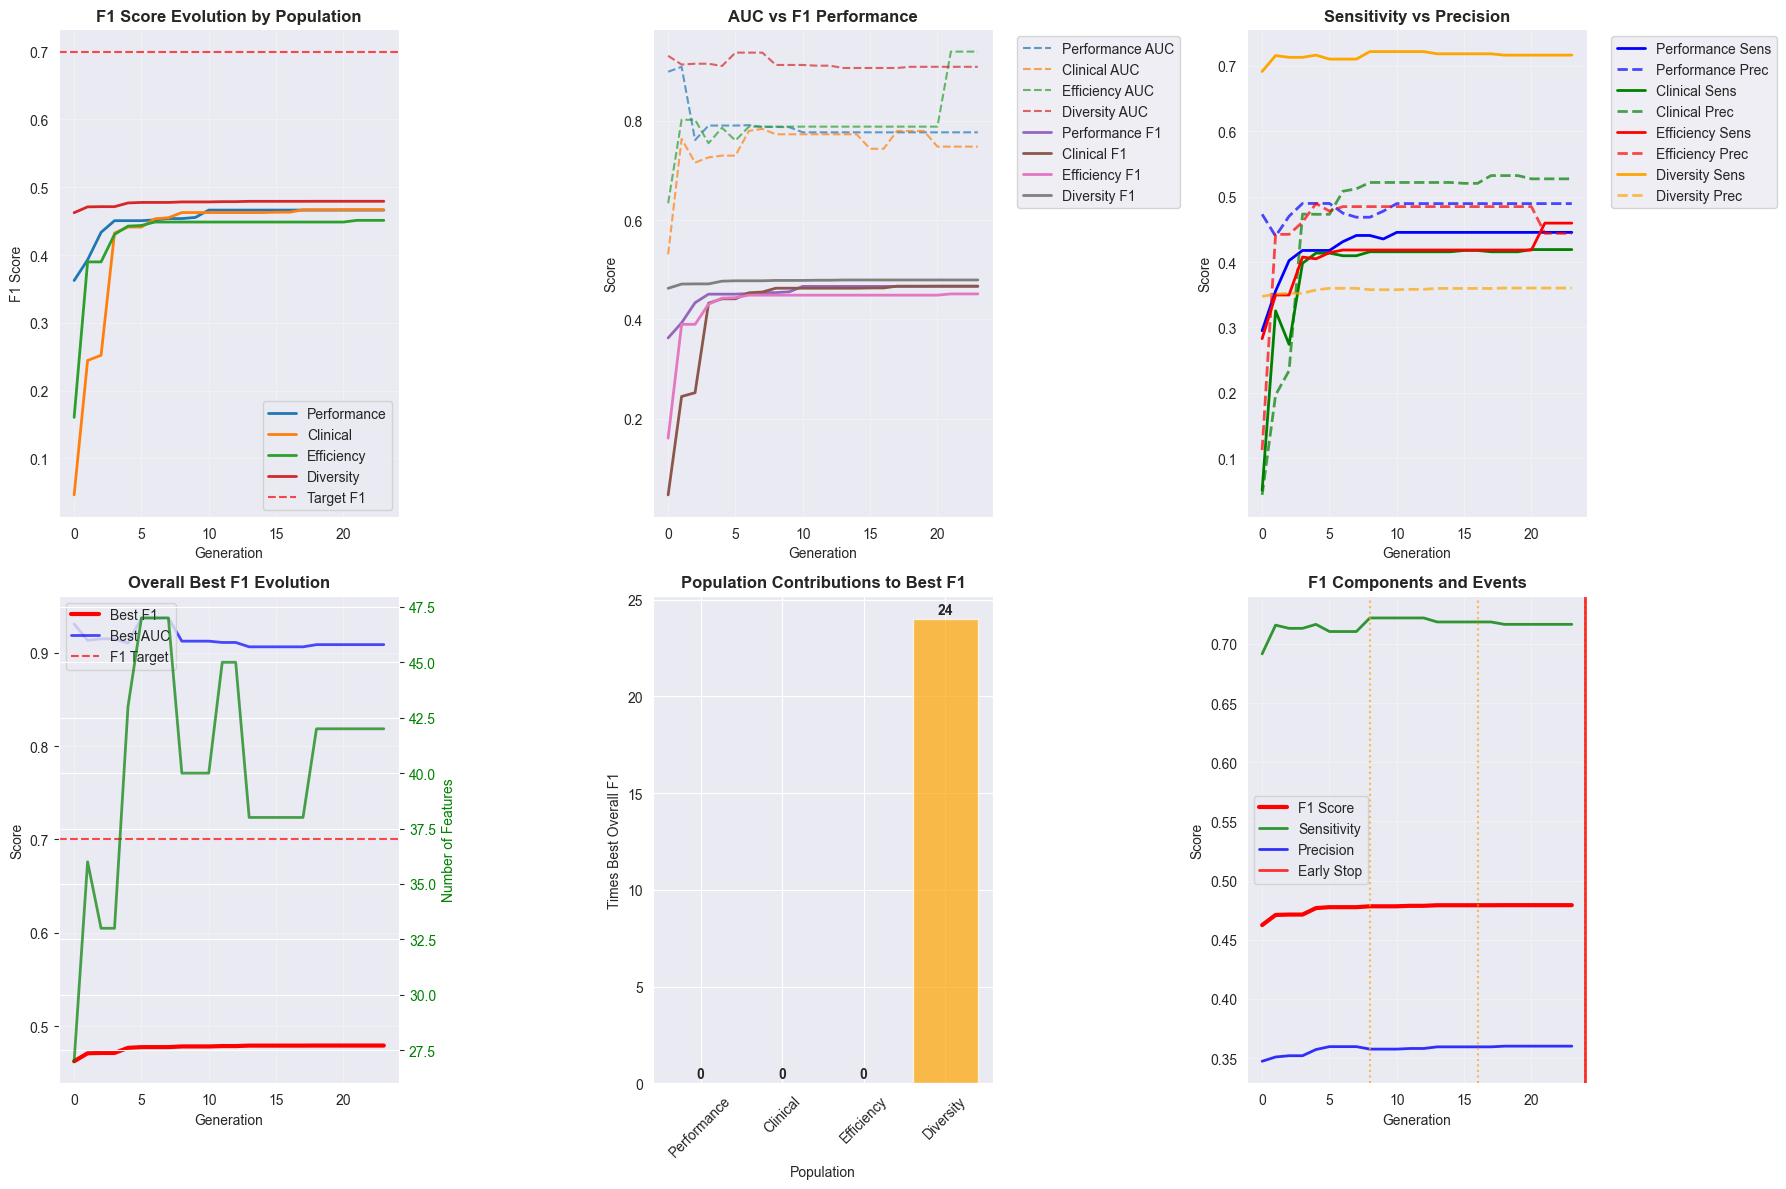


✅ F1-optimized multi-population GA experiment completed and saved!
📊 Evolution plots saved as 'f1_multi_population_ga_evolution.png'

📊 F1-Optimized Multi-Population GA Results Summary:
Method                         Population   F1       AUC      Sens     Prec     Features  Clinical 
----------------------------------------------------------------------------------------------------
GA_F1MultiPop_Performance      Performance  0.4193   0.7556   0.3757   0.4744   40        0.675    
GA_F1MultiPop_Clinical         Clinical     0.4120   0.7305   0.3703   0.4644   35        0.694    
GA_F1MultiPop_Efficiency       Efficiency   0.3988   0.9341   0.3622   0.4437   32        0.359    
GA_F1MultiPop_Diversity        Diversity    0.4639   0.8968   0.6946   0.3482   42        0.510    

🏥 F1-Optimized Clinical Impact Analysis:

🎯 Best F1 Performance: GA_F1MultiPop_Diversity (F1=0.4639)

GA_F1MultiPop_Performance (Performance):
  🎯 F1 Score: 0.4193 ❌ POOR
  ✅ Cancer cases found: 139/370 (37.6%)


In [28]:
if __name__ == "__main__":
    results, populations, evolution_history = main()

In [27]:
mlflow.end_run()

In [25]:
# View experiment results in MLflow UI
print("\n🎯 To view results in MLflow UI, run:")
print("   mlflow ui")
print("   Then open http://localhost:5000")
print(f"\n📁 MLflow artifacts are stored in: {mlflow.get_tracking_uri()}")
print(f"🏷️  Experiment name: {experiment_name}")


🎯 To view results in MLflow UI, run:
   mlflow ui
   Then open http://localhost:5000

📁 MLflow artifacts are stored in: mlruns
🏷️  Experiment name: MultiPopGA_BreastCancer_20251226_140149


In [41]:
import joblib

model = joblib.load("ga_f1_multi_population_experiment.pkl")


In [43]:
import mlflow
import mlflow.sklearn

with mlflow.start_run(run_id="6e6c38f2a2ff45bb932afa835fda1949"):
    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="model",
        registered_model_name="F1_MultiPopGA_BreastCancer"
    )


2025/12/31 16:23:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/31 16:23:06 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/12/31 16:23:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'F1_MultiPopGA_BreastCancer'.
Created version '1' of model 'F1_MultiPopGA_BreastCancer'.


## Additional MLflow Features

### 1. Compare Runs
Use MLflow UI to compare different GA runs with different configurations.

### 2. Parameter Search
Create multiple runs with different GA configurations:

In [ ]:
# Example: Parameter search with MLflow
param_grid = {
    'mutation_rate': [0.01, 0.05, 0.1],
    'crossover_rate': [0.7, 0.8, 0.9],
    'migration_frequency': [5, 10, 20]
}

# Run experiments with different parameters
for mut_rate in param_grid['mutation_rate']:
    for cross_rate in param_grid['crossover_rate']:
        for mig_freq in param_grid['migration_frequency']:
            with mlflow.start_run(run_name=f"GA_mut{mut_rate}_cross{cross_rate}_mig{mig_freq}"):
                # Update config
                ga_config['mutation_rate_base'] = mut_rate
                ga_config['crossover_rate_base'] = cross_rate
                ga_config['migration_frequency'] = mig_freq
                
                # Run experiment
                # results = run_complete_ga_experiment()
                
                print(f"Completed run with mut={mut_rate}, cross={cross_rate}, mig={mig_freq}")

### 3. Model Comparison
Load and compare models from different runs:

In [39]:
"""
Notebook script to analyze your MLflow models
Run this directly in a Jupyter cell
"""

import mlflow
import pandas as pd
from mlflow.tracking import MlflowClient

# Fix 1: Make sure MLflow tracking URI is set correctly
# If you're running MLflow locally, it's usually http://localhost:5000
mlflow.set_tracking_uri("mlruns")

# Alternative URIs to try:
# mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.set_tracking_uri("file:///path/to/mlruns")  # If using file store

print("🔍 Connecting to MLflow...")

try:
    client = MlflowClient()

    # List all experiments to verify connection
    experiments = client.search_experiments()
    print(f"✅ Connected! Found {len(experiments)} experiments")

    # Find your experiment
    experiment_name = "F1_Optimized_MultiPopGA_BreastCancer"
    experiment = None

    for exp in experiments:
        print(f"  - {exp.name}")
        if exp.name == experiment_name:
            experiment = exp

    if not experiment:
        print(f"\n❌ Experiment '{experiment_name}' not found!")
        print("Available experiments:")
        for exp in experiments:
            print(f"  - {exp.name}")
    else:
        print(f"\n✅ Found experiment: {experiment_name}")

        # Get runs from the experiment
        runs_df = mlflow.search_runs(
            experiment_ids=[experiment.experiment_id],
            order_by=["start_time DESC"],
            max_results=20
        )

        print(f"\n📊 Found {len(runs_df)} runs")

        # Look for your specific models
        model_names = ["Diversity", "Efficiency", "Clinical", "Performance"]

        print("\n🏆 Model Performance:")
        print("-" * 80)
        print(f"{'Population':<15} {'F1 Score':<10} {'AUC':<10} {'Sensitivity':<12} {'Features':<10} {'Run ID':<20}")
        print("-" * 80)

        best_f1 = 0
        best_model = None
        best_run_id = None

        for _, run in runs_df.iterrows():
            # Check if this run is one of our populations
            tags = run.get('tags.mlflow.runName', '')
            run_name = run.get('tags.mlflow.runName', '')

            for model in model_names:
                if model.lower() in str(tags).lower() or model.lower() in str(run_name).lower():
                    # Get metrics - try different possible names
                    f1 = run.get('metrics.test_f1',
                         run.get('metrics.f1_score',
                         run.get('metrics.F1', 0)))

                    auc = run.get('metrics.test_auc',
                          run.get('metrics.auc',
                          run.get('metrics.AUC', 0)))

                    sensitivity = run.get('metrics.test_sensitivity',
                                  run.get('metrics.sensitivity',
                                  run.get('metrics.recall', 0)))

                    n_features = run.get('params.n_selected_features',
                                 run.get('params.n_features', 'N/A'))

                    run_id = run['run_id'][:20] + "..."

                    print(f"{model:<15} {f1:<10.4f} {auc:<10.4f} {sensitivity:<12.4f} {n_features:<10} {run_id:<20}")

                    if f1 > best_f1:
                        best_f1 = f1
                        best_model = model
                        best_run_id = run['run_id']
                    break

        print("-" * 80)
        print(f"\n🥇 Best Model: {best_model} (F1: {best_f1:.4f})")
        print(f"   Run ID: {best_run_id}")

        # Check registered models
        print("\n\n📦 Checking Registered Models:")
        print("-" * 40)

        registered_models = ["Diversity_final_model", "Efficiency_final_model",
                           "Clinical_final_model", "Performance_final_model"]

        for model_name in registered_models:
            try:
                versions = client.get_latest_versions(model_name)
                if versions:
                    v = versions[0]
                    print(f"✅ {model_name}: Version {v.version}, Stage: {v.current_stage}")
                else:
                    print(f"❌ {model_name}: No versions found")
            except:
                print(f"❌ {model_name}: Not found in registry")

except Exception as e:
    print(f"\n❌ Error: {e}")
    print("\n🔧 Troubleshooting:")
    print("1. Make sure MLflow is running: mlflow ui")
    print("2. Check the tracking URI - default is http://localhost:5000")
    print("3. If using file store, set: mlflow.set_tracking_uri('file:///absolute/path/to/mlruns')")
    print("4. Try in terminal: curl http://localhost:5000/api/2.0/mlflow/experiments/search")

🔍 Connecting to MLflow...
✅ Connected! Found 6 experiments
  - F1_Optimized_MultiPopGA_BreastCancer
  - MultiPopGA_BreastCancer_20251226_140149
  - MultiPopGA_BreastCancer_20251226_140101
  - MultiPopGA_BreastCancer_20251226_135756
  - MultiPopGA_BreastCancer_20251223_164237
  - Default

✅ Found experiment: F1_Optimized_MultiPopGA_BreastCancer

📊 Found 1 runs

🏆 Model Performance:
--------------------------------------------------------------------------------
Population      F1 Score   AUC        Sensitivity  Features   Run ID              
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

🥇 Best Model: None (F1: 0.0000)
   Run ID: None


📦 Checking Registered Models:
----------------------------------------
❌ Diversity_final_model: Not found in registry
❌ Efficiency_final_model: Not found in registry
❌ Clinical_final_model: Not found in registry
❌ Performance_final_model: 

In [40]:
# Model promotion workflow
client = mlflow.tracking.MlflowClient()

# Register model
model_version = client.create_model_version(
    name="breast_cancer_ga_model",
    source=model_name,
    run_id=run['run_id'][:20] + "..."
)

# Transition stages
client.transition_model_version_stage(
    name="breast_cancer_ga_model",
    version=model_version.version,
    stage="Staging",
    archive_existing_versions=False
)

# After validation
client.transition_model_version_stage(
    name="breast_cancer_ga_model",
    version=model_version.version,
    stage="Production",
    archive_existing_versions=True
)

MlflowException: Model Version creation error (name=breast_cancer_ga_model). Error: Registered Model with name=breast_cancer_ga_model not found. Giving up after 3 attempts.

In [ ]:
# Load a logged model
# model_uri = "runs:/<RUN_ID>/model"
# loaded_model = mlflow.sklearn.load_model(model_uri)

# Compare predictions
# predictions = loaded_model.predict(X_test)